In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.collections import PolyCollection

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as Model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
# Store specific predictions, for the paper 'use case' section.
#
execute_this_cell = True
if execute_this_cell:
    importlib.reload(Model)
    importlib.reload(Simulation_config)
    importlib.reload(utils)
    importlib.reload(ModelTrainer)

    # Get specific results
    #
    result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                        print_style = 'pandas_df')

    # Define a specific configuration
    #
    myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

    modelTrainer = ModelTrainer.ModelTrainer()
    loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
    modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                                train_size = myConfig.trainingHistory,
                                                test_size = modelTrainer.test_set_size_days, 
                                                prediction_history = myConfig.modelInputHistory,
                                                )
    community_id = 0  # chose one of many energy communites
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
    num_of_features = X['train'].shape[2]
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

    # Store the predicted power profiles
    #
    for model_type in Simulation_config.UsedModels.ALL:
        test_profile = f"scripts/outputs/file_{community_id}.pkl"
        my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
        Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
        P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

    startdate = modelAdapter.getStartDateFromIndex('test', 0)
    file_path = "scripts/outputs/example_predictions.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump((P_el_predicted, startdate), file)

    print(P_el_predicted.shape)
    print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


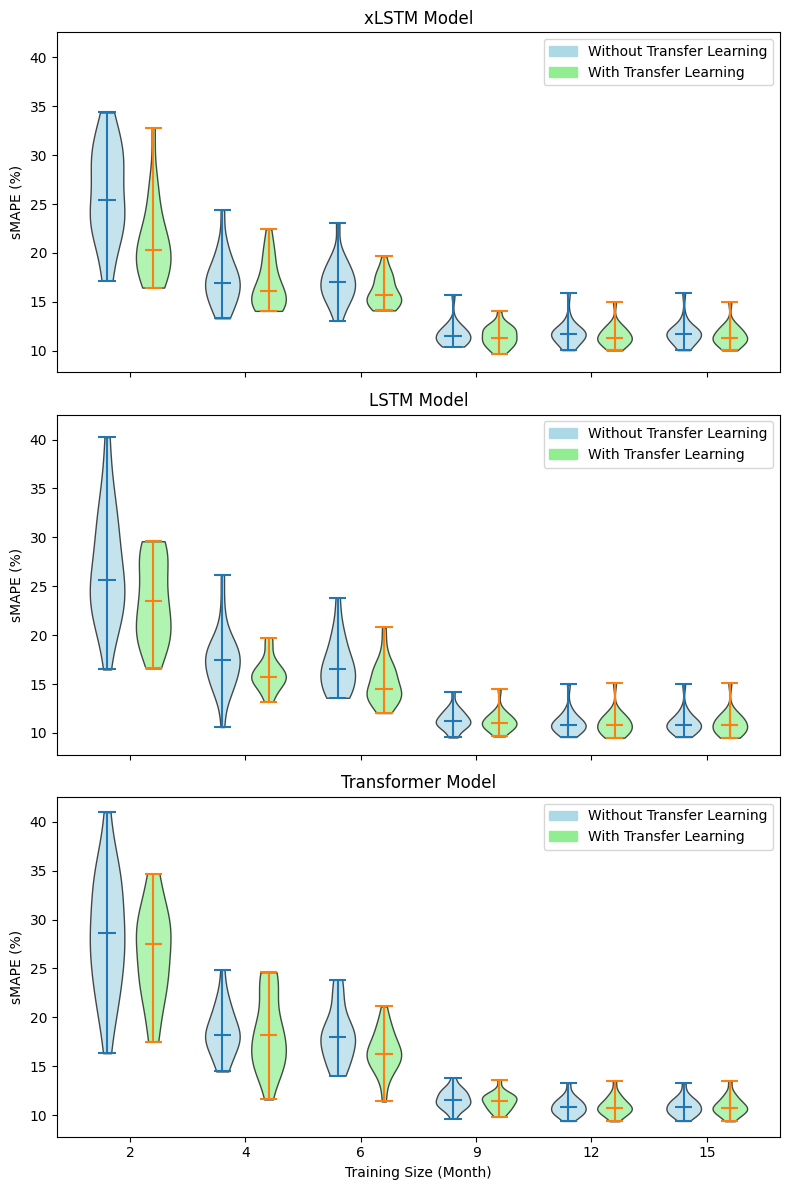

In [3]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ['xLSTM', 'LSTM', 'Transformer']
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0    
    quantiles = [[0.25, 0.75] for _ in data_with]
    
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=False, showextrema=True, showmedians=True)       #quantiles=quantiles
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=False, showextrema=True, showmedians=True)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.savefig("scripts/outputs/transfer_learning_over_train_size.pdf", format="pdf")
plt.tight_layout()
plt.show()


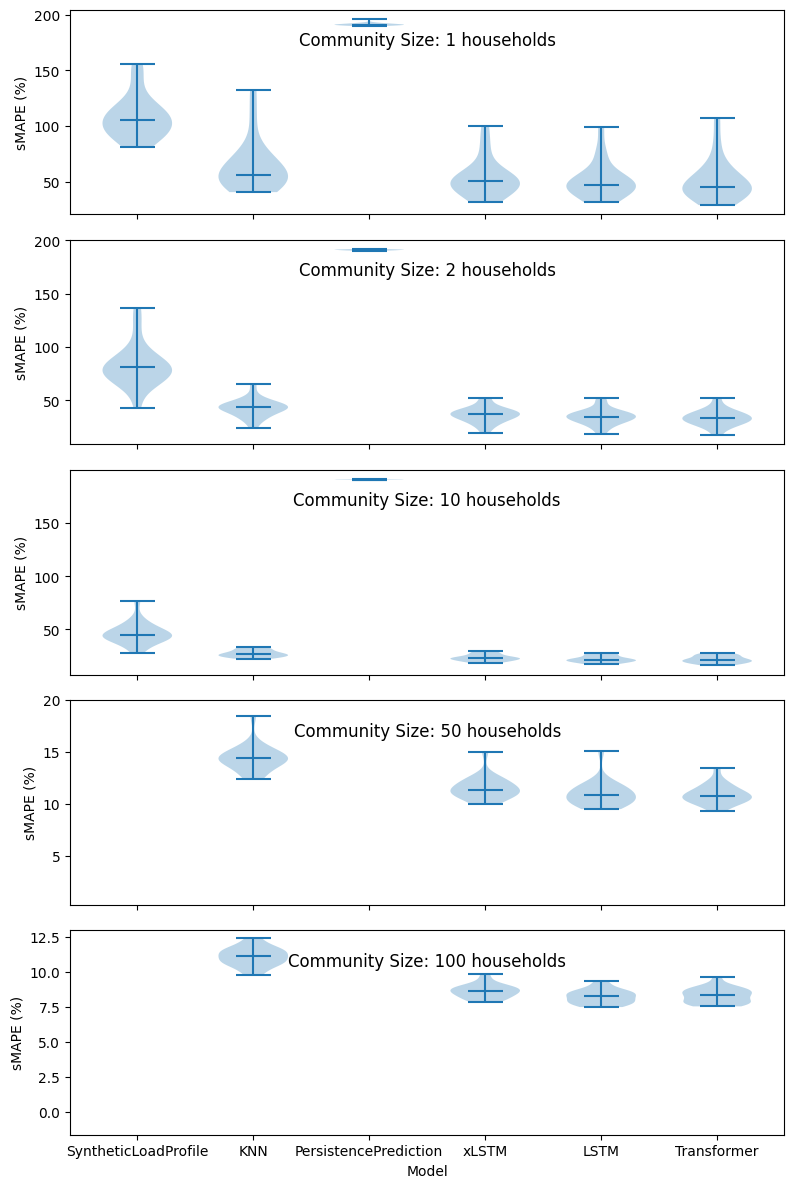

In [4]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = configs[0].usedModels
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(8, 12), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                            showmeans=False, showextrema=True, showmedians=True)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.text(0.5, 0.85, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    
    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

axes[0].set_ylim(None, None)
axes[1].set_ylim(None, None)
axes[2].set_ylim(None, None)
axes[3].set_ylim(None, 20)
axes[4].set_ylim(None, 13)
plt.tight_layout()
plt.savefig("scripts/outputs/error_over_community_size.pdf", format="pdf")
plt.show()


In [2]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    
    # Without transfer learning:
    #
    
    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
config_names = ['Small', 'Medium (Baseline)', 'Large', 
                '1', '2', '10', '50 (Baseline)', '100',
                '2 mo', '6 mo', '12 mo', '15 mo (Baseline)',
                '2 days (Baseline)', '7 days', '21 days',
                ]
config_groups = [('Model Size', 3), '-', '-', 
                ('Aggregation', 4), '-', '-', '-', '-',
                ('Training Size', 4), '-', '-', '-',
                ('Input Seq Length', 3), '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
configs_without_transfer_learning = printed_configs[len(config_names):]

assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning) == len(configs_without_transfer_learning), \
        f"Unexpected list length: {len(configs)} != {len(config_names)} != {len(configs_with_transfer_learning)} != {len(configs_without_transfer_learning)}"

def print_latex_string(configs):
        latex_string = ''
        for i, expected_config in enumerate(configs):
                expected_config_found = False
                if config_groups[i] != '-':
                        latex_string += '\\hline\n'
                        latex_string += f'\\multirow{{{config_groups[i][1]}}}{{*}}{{\\textbf{{{config_groups[i][0]}}}}} \n'
                latex_string += f'    & {config_names[i]}'
                for available_config in result_dict:
                        if expected_config == available_config:
                                expected_config_found = True
                                for model_type, test_sMAPE in result_dict[available_config].items():
                                        decimal_points = 2
                                        median_test_sMAPE = f'{np.median(test_sMAPE):.{decimal_points}f}'
                                        siqr_test_sMAPE = f'{(np.percentile(test_sMAPE,75)-np.percentile(test_sMAPE,25))/2.0:.{decimal_points}f}'
                                        latex_string += f' & {median_test_sMAPE} ({siqr_test_sMAPE})'
                                latex_string += ' \\\ \n'
                if expected_config_found == False:
                        # expected config wasn't found in the test run file
                        latex_string += ' & - & - & - & - & - & - \\\ \n'
        print(latex_string)

print_latex_string(configs_with_transfer_learning)
print_latex_string(configs_without_transfer_learning)


\hline
\multirow{3}{*}{\textbf{Model Size}} 
    & Small & - & - & - & - & - & - \\ 
    & Medium (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 12.92 (0.62) \\ 
    & Large & - & - & - & - & - & - \\ 
\hline
\multirow{4}{*}{\textbf{Aggregation}} 
    & 1 & - & - & - & - & - & - \\ 
    & 2 & - & - & - & - & - & - \\ 
    & 10 & - & - & - & - & - & - \\ 
    & 50 (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 12.92 (0.62) \\ 
    & 100 & - & - & - & - & - & - \\ 
\hline
\multirow{4}{*}{\textbf{Training Size}} 
    & 2 mo & - & - & - & - & - & - \\ 
    & 6 mo & - & - & - & - & - & - \\ 
    & 12 mo & 27.36 (1.32) & 14.41 (0.45) & 12.92 (0.62) \\ 
    & 15 mo (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 12.92 (0.62) \\ 
\hline
\multirow{3}{*}{\textbf{Input Seq Length}} 
    & 2 days (Baseline) & 27.36 (1.32) & 14.41 (0.45) & 12.92 (0.62) \\ 
    & 7 days & - & - & - & - & - & - \\ 
    & 21 days & - & - & - & - & - & - \\ 

\hline
\multirow{3}{*}{\textbf{Model Size}} 
    & Small & - & - & - & - 